In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
tf.__version__

'2.10.1'

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [3]:
# Avoid OOM error by setting GPU memory consumption growth
gpus  = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [4]:
len(gpus)

1

## 1.1 Load Dataset

In [6]:
#pd.read_csv('WISDM_ar_latest/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')
# there is error  in load the dataset, because some line problem, ie, data is overmapping the dataset
# so we need to do some tweek in the data structure

In [7]:
file = open('WISDM_ar_latest/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')
lines = file.readlines()

In [8]:
# some line contains extra data, so we need to remove them
processed_list = []
for i , line in enumerate(lines):
    try:
        line = line.split(',')
        last = line[5].split(';')[0]
        last = last.strip()
        if last == '' :
            break
        temp = [line[0], line[1], line[2], line[3],line[4],last]
        processed_list.append(temp)
    except:
        print('error at line number', i)
    

error at line number 281873
error at line number 281874
error at line number 281875


In [9]:
column = ['user', 'activity', 'time', 'x', 'y', 'z']
df = pd.DataFrame(data=processed_list,columns=column)
df.head()

,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


In [10]:
df.shape

(343416, 6)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343416 entries, 0 to 343415
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user      343416 non-null  object
 1   activity  343416 non-null  object
 2   time      343416 non-null  object
 3   x         343416 non-null  object
 4   y         343416 non-null  object
 5   z         343416 non-null  object
dtypes: object(6)
memory usage: 15.7+ MB


In [12]:
df['activity'].value_counts()
# data is not balanced, so we need to balance the data

Walking       137375
Jogging       129392
Upstairs       35137
Downstairs     33358
Sitting         4599
Standing        3555
Name: activity, dtype: int64

## 1.2 Balance the data

In [13]:
df['x'] = df['x'].astype(float)
df['y'] = df['y'].astype(float)
df['z'] = df['z'].astype(float)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343416 entries, 0 to 343415
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user      343416 non-null  object 
 1   activity  343416 non-null  object 
 2   time      343416 non-null  object 
 3   x         343416 non-null  float64
 4   y         343416 non-null  float64
 5   z         343416 non-null  float64
dtypes: float64(3), object(3)
memory usage: 15.7+ MB


In [15]:
fs = 20

In [16]:
activities = df['activity'].value_counts().index


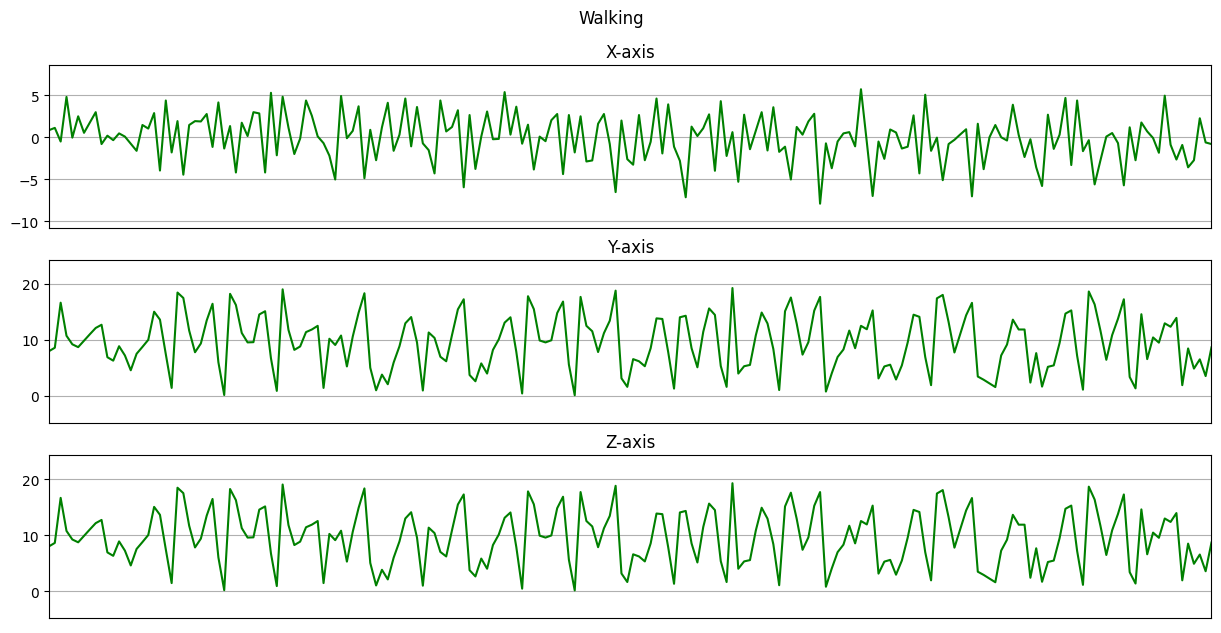

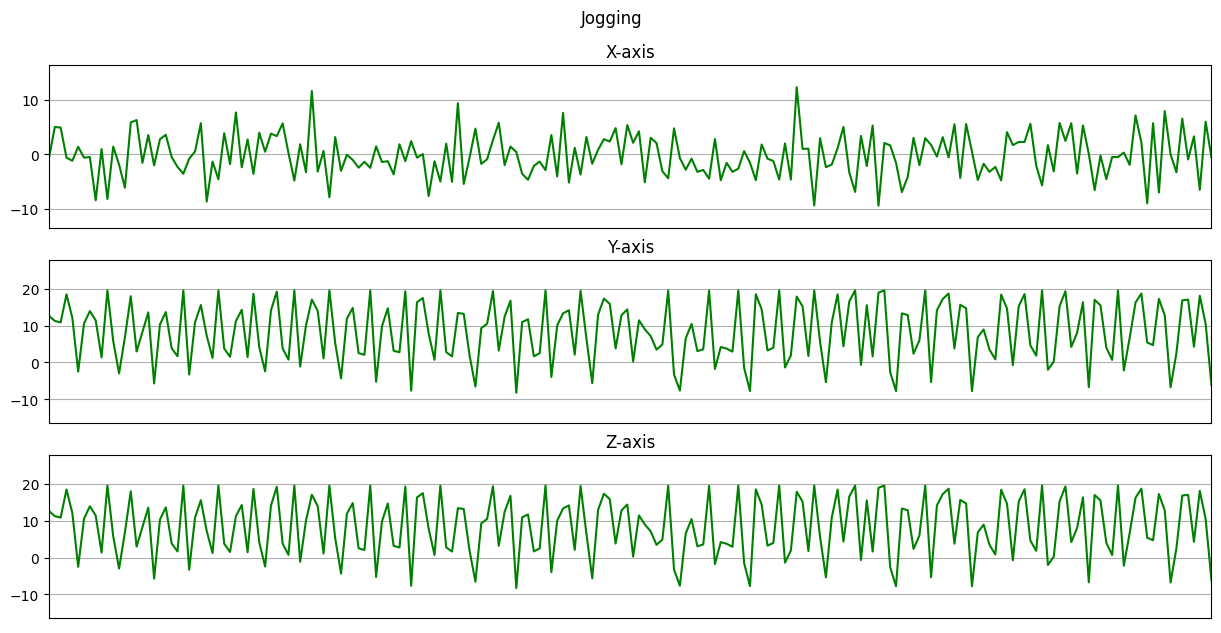

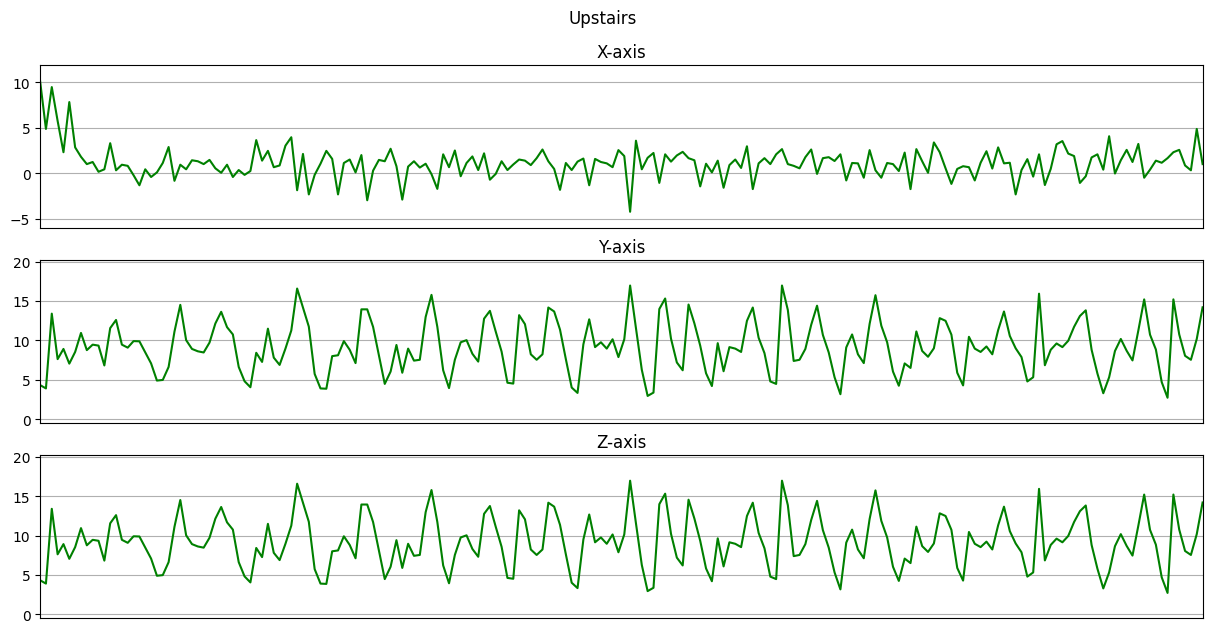

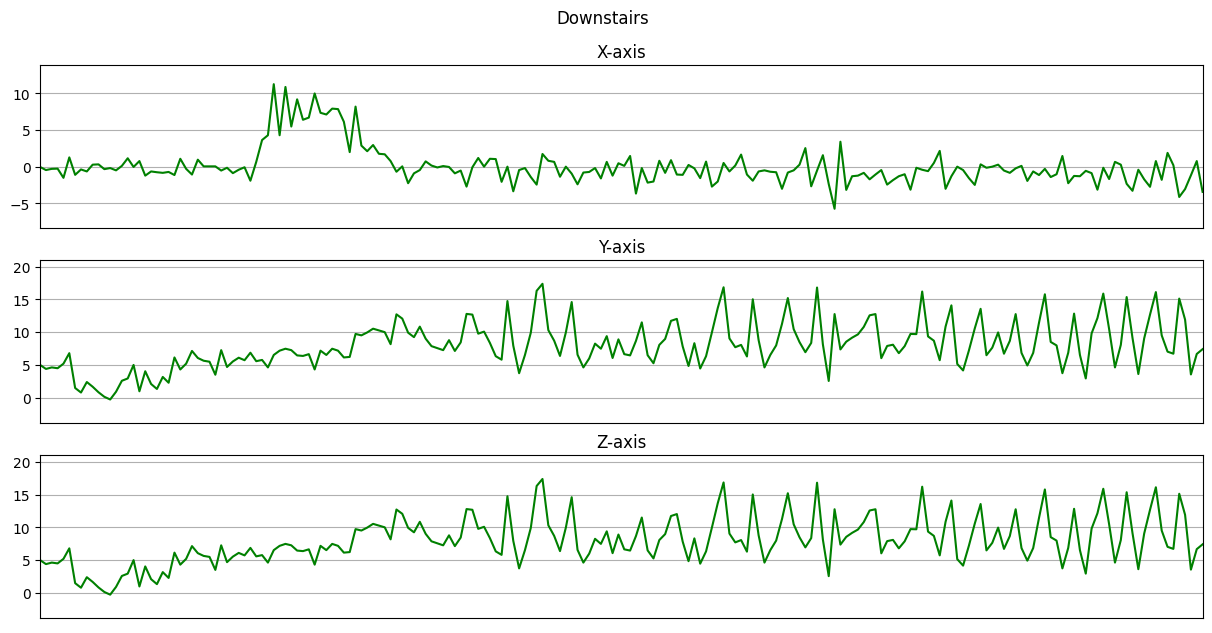

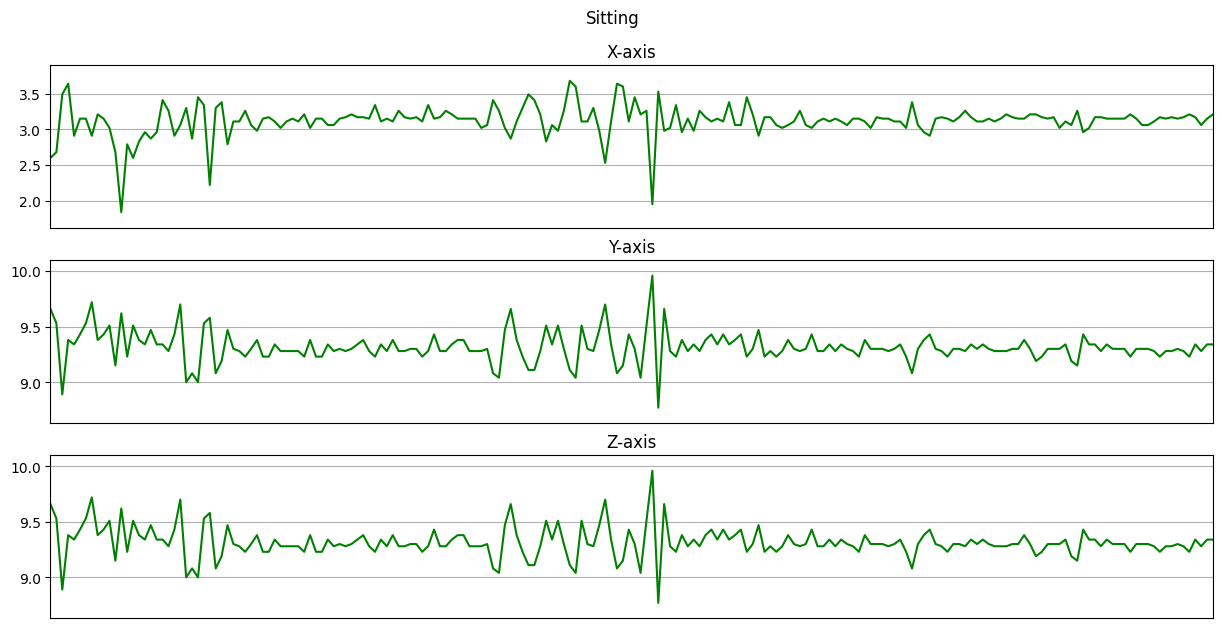

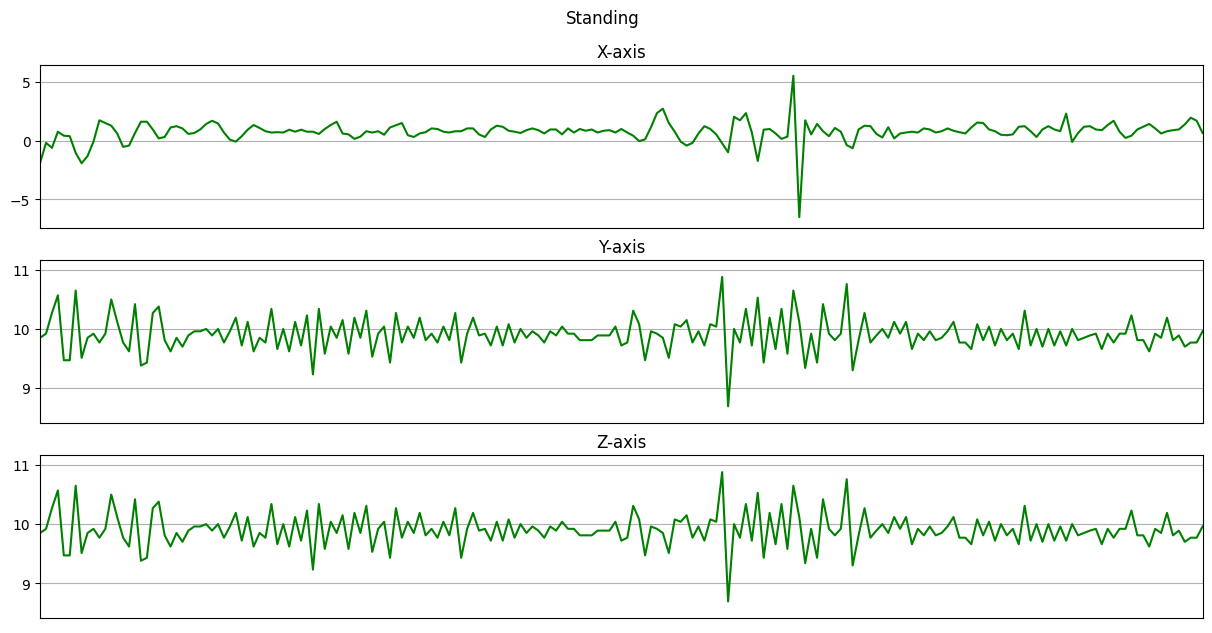

In [17]:
def plot_activity(activity,data):
    fig,(ax0,ax1,ax2) = plt.subplots(nrows=3, figsize = (15,7),sharex=True)
    plot_axis(ax0,data['time'], data['x'], 'X-axis')
    plot_axis(ax1,data['time'], data['y'], 'Y-axis')
    plot_axis(ax2,data['time'], data['y'], 'Z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()
    
def plot_axis(ax, x, y, title):
    ax.plot(x,y,'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
for activity in activities:
    data_for_plot = df[(df['activity'] == activity)][:fs*10]
    plot_activity(activity, data_for_plot)


In [18]:
jogging = df[df['activity'] == 'Jogging'].head(3555).copy()
walking = df[df['activity'] == 'Walking'].head(3555).copy()
upstairs = df[df['activity'] == 'Upstairs'].head(3555).copy()
downstairs = df[df['activity'] == 'Downstairs'].head(3555).copy()
sitting = df[df['activity'] == 'Sitting'].head(3555).copy()
standing = df[df['activity'] == 'Standing'].head(3555).copy()


In [19]:
# create data set ny pandas concat
balanced_data = pd.concat([jogging,walking,upstairs,downstairs,sitting,standing])
balanced_data['activity'].value_counts()

Jogging       3555
Walking       3555
Upstairs      3555
Downstairs    3555
Sitting       3555
Standing      3555
Name: activity, dtype: int64

In [20]:
balanced_data

,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
257318,36,Standing,15049012250000,-0.910000,9.430000,2.533385
257319,36,Standing,15049062268000,-1.180000,9.510000,2.492524
257320,36,Standing,15049112287000,-1.500000,9.530000,2.533385
257321,36,Standing,15049162275000,-2.070000,8.770000,2.179256


## 1.3 Encord the data

In [21]:
from sklearn.preprocessing import LabelEncoder

In [22]:
# Encord the activity column to number
label = LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['activity'])

In [23]:
balanced_data.head()

,user,activity,time,x,y,z,label
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1


In [24]:
balanced_data['label'].unique()

array([1, 5, 4, 0, 2, 3])

In [25]:
# if we want see the class of encorded classes
label.classes_

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

In [26]:
balanced_data = balanced_data.drop(['user', 'time'], axis=1)
balanced_data.head()

,activity,x,y,z,label
0,Jogging,-0.694638,12.680544,0.503953,1
1,Jogging,5.012288,11.264028,0.953424,1
2,Jogging,4.903325,10.882658,-0.081722,1
3,Jogging,-0.612916,18.496431,3.023717,1
4,Jogging,-1.184970,12.108489,7.205164,1


## 1.4 Standardize the data

In [27]:
x = balanced_data[['x','y','z']]
y = balanced_data['label']


In [28]:
scaler = StandardScaler()
standardized_data = scaler.fit_transform(x)

standardized_data.shape

(21330, 3)

In [29]:
y = pd.DataFrame(y, columns=['label'])
y = y.astype(int)


In [30]:
standardized_data.shape

(21330, 3)

In [31]:
df1 = pd.DataFrame(data=standardized_data, columns=['x','y','z'])
df1['label'] = y.values
df1

,x,y,z,label
0,-0.412436,0.812245,-0.342151,1
1,1.118728,0.535892,-0.208563,1
2,1.089493,0.461489,-0.516221,1
3,-0.390510,1.946888,0.406751,1
4,-0.543991,0.700641,1.649525,1
...,...,...,...,...
21325,-0.470217,0.178084,0.261019,3
21326,-0.542658,0.193692,0.248875,3
21327,-0.628514,0.197593,0.261019,3
21328,-0.781444,0.049322,0.155768,3


## 1.5 frame prepration

In [32]:
# 1 second = 1000 millisecond
# here we use 4 second data for one cycle input,
# for 1 second we get 20 readings
# for 4 second = 20 * 4

In [33]:
fs = 20  # 20 readings for 1 second
frame_size = fs * 4 # frame size is 4 second
hop_size = fs * 2 # do we need overlap or  not, here we overlap every 2 second

In [34]:
import scipy.stats as stat

In [35]:
def get_frames (data, frame_size, hop_size):
    
    frames = []
    labels = []
    for i in range(0  , len(data) - frame_size, hop_size):
        x = data['x'].values[i: i+ frame_size]
        y = data['y'].values[i: i+ frame_size]
        z = data['z'].values[i: i+ frame_size]

        label = stat.mode(data['label'].values[i : i + frame_size])[0][0] # mode
        frames.append([x,y,z])
        labels.append(label)
    frames = np.asarray(frames).reshape( -1, frame_size, 3)
    labels = np.asarray(labels)
    
    return frames, labels

## 1.6 Data preprocessing 

In [36]:
x, y = get_frames(df1, frame_size, hop_size)
x.shape, y .shape

C:\Users\Asus\AppData\Local\Temp\ipykernel_11220\3535252606.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stat.mode(data['label'].values[i : i + frame_size])[0][0] # mode


((532, 80, 3), (532,))

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=42, stratify=y) 
# by use stratified = y, class propotion are the same for traina and test. 

In [38]:
x_train.shape, x_test.shape

((399, 80, 3), (133, 80, 3))

# 2 Model prepration

In [39]:
x_train[1].shape, x_test[1].shape

((80, 3), (80, 3))

##### CNN only accept 3D data into the network , Here we have 2D data. so we need to reshape 3D data. ie, one sample contain (80,3) data. so we need to convert to 3D data. (number of sample, 80,3,1)

In [40]:
x_train = x_train.reshape(399,80,3,1)

x_test = x_test.reshape(133,80,3,1)

In [41]:
x_train.shape

(399, 80, 3, 1)

In [42]:
x_train.shape

(399, 80, 3, 1)

## 2.1 CNN

In [43]:
model = Sequential()
model.add(Conv2D(16, (2,2), activation='relu',input_shape= (80, 3, 1)))
model.add(Dropout(0.1))

model.add(Conv2D(8, (2,2), activation='relu'))
model.add(Dropout(0.1))


model.add(Flatten())
model.add(Dense(16, activation='relu'))

model.add(Dense(6, activation='sigmoid'))
          

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 79, 2, 16)         80        
                                                                 
 dropout (Dropout)           (None, 79, 2, 16)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 78, 1, 8)          520       
                                                                 
 dropout_1 (Dropout)         (None, 78, 1, 8)          0         
                                                                 
 flatten (Flatten)           (None, 624)               0         
                                                                 
 dense (Dense)               (None, 16)                10000     
                                                                 
 dense_1 (Dense)             (None, 6)                 1

In [45]:
model.compile(optimizer='adam' ,loss='sparse_categorical_crossentropy', metrics= ['accuracy'] )

In [ ]:
hist = model.fit(x_train,y_train, epochs=10, validation_data=(x_test,y_test), verbose=1)

Epoch 1/10


In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('loss', fontsize = 20)
plt.legend(loc='upper right')
plt.show()


In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'val_loss')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc='upper right')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
## checking the  predicted value. argmax is finding the index value of max probability index of y_hat.
np.argmax(y_hat[1])

In [ ]:
y_test

In [ ]:
# checking the predicted and real value are same or not
y_test[1]
# y_hat and y_test are right

In [ ]:
import keras

In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
param_distribs = {
 "n_hidden": [0, 1, 2, 3],
 "n_neurons": np.arange(1, 200),
 "learning_rate": reciprocal(3e-4, 3e-2, 0.001)
}

In [ ]:
param_distribs

In [ ]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(model)


In [ ]:
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(x_train, y_train, epochs=100,
 validation_data=(x_test, y_test),
 callbacks=[keras.callbacks.EarlyStopping(patience=10)])